<a href="https://colab.research.google.com/github/arnaldocavalcanti/14ia_GCP/blob/main/Projeto_object_people_audit_colab_FIAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto usando Inteligência Artificial & Machine Learning 

## Visão Computacional: Auditoria Automática de Vídeo Baseada em Modelos de Deep-Learning

> Atenção: este notebook foi desenhado para funcionar no **Google Collab**. Se pretende executar no Collab, prefira a versão **PRO** pois só assim conseguirá ter um melhor rendimento.

### **Autor:** Arnaldo Cavalcanti
Email: naldocavalcanti@gmail.com <br>
Linkedin: https://www.linkedin.com/in/arnaldojrcavalcanti/



## 1. Introdução

Este projeto foi o meu projeto final do MBA de Inteligência artificial da FIAP e tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas. A ideia é construir uma aplicação que tem por objetivo analisar imagens e extrair uma série de informações que serão utilizadas para compor uma análise de imagens e vídeos afim de fazer uma de auditoria automatizada baseado em modelos de inteligência artificial.


<p align="center">
<img src="https://github.com/michelpf/fiap-ml-visao-computacional-capstone/blob/master/projeto/imagens-aux/example.png?raw=1">
</p>

**Entregas:**
 
1. __Modelo de identificação de idades__
2. __Modelo de identificação de gênero__
3. __Extração de faces (região de interesse)__
4. __Análise de vídeo e extração de objetos__
5. __Conclusões Finais__



### 1.1 Componentes obrigatórios

Todas as bibliotecas já estão instaladas no Google Colab.

* Keras
* Scikit-learn
* Seaborn
* DLib
* OpenCv
* Pandas
* Numpy

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,2,3,4"

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tqdm import tqdm

#Exibição na mesma tela do Jupyter
%matplotlib inline

from os import listdir
from os.path import isfile, join

import pandas as pd
import dlib

import ast 
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, ZeroPadding2D, Convolution2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})


Num GPUs Available:  1


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


### 1.1.1 Utilizando Google Drive

Se quiser usar o Google Drive para armazenar as imagens utilize o comando abaixo para montar seu drive.
Você pode navegar pelas pastas pelo painel ao lado.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.1.2 Utilizando o armazenamento efêmero

Se optar pelo armazenamento efêmero você precisa enviar os arquivos de imagens (arrastar e soltar) para as pastas que deverão ser criadas na estrutura do Colab e nas pastas que serão criadas no clone do repositório.

### 1.1.3 Materiais de suporte e conjunto de dados

As imagens e vídeos que serão utilizados no projeto estão no repositório do meu mestre, professor Michel Fernandes. Para utiliza-las você precisá fazer o clone do repositório dele através do comando abaixo: (https://www.linkedin.com/in/michelpf/)

In [6]:
!git clone https://github.com/michelpf/fiap-ml-visao-computacional-capstone

fatal: destination path 'fiap-ml-visao-computacional-capstone' already exists and is not an empty directory.


Entrando na pasta gerada pelo clone executado acima

In [7]:
%cd fiap-ml-visao-computacional-capstone/projeto/

/content/fiap-ml-visao-computacional-capstone/projeto


## 1.2 O problema

Atualmente, com a tecnologia disponível e acessível, sobretudo na obtenção de imagens e vídeos e em seu processamento, permite apoiar com mais ênfase atividades de auditoria e investigação de forma automatizada, sem a necessidade de uma pessoa realizar tais análises e ainda com maior acurácia.

O uso de tecnologias relacionadas a visão computacional pode contribuir para tornar mais eficiente investigações de pessoas e objetos baseadas em suas características e em seu perfil, além de tornar esta atividade mais rápida e completa.

A proposta deste projeto é apoiar uma aplicação de auditoria e investigação para automatizar a busca por regiões de interesse (objetos e determinadas pessoas) com as seguintes finalidades:

* Encontrar pessoas do gênero masculino com mais de 45 anos de idade
* Encontrar pessoas do gênero femimino com menos de 45 anos de idade
* Encontrar objetos relacionados a informática, como computadores e telefones

Uma busca manual em vídeos de vigilância é bem onerosa e pode deixar passar evidências importantes em processos investigativos.

Ainda assim, a análise humana é realizada em último caso para decidir, se dentre as evidências coletadas, quais devem seguir para investigação mais apurada e quais não. A tarefa humana é mais de validação do que exploração.

Para alcançar este objetivo iremos construir uma aplicação capaz de analisar um vídeo específico de um escritório, baseado na série de TV [_The Office_](https://pt.wikipedia.org/wiki/The_Office). A partir dele e de modelos de classificação de imagens, iremos coletar e armazenar imagens das regiões de interesse citadas para posterior análise de investigações.

Deste modo, seguiremos com o seguinte roteiro:

* Desenvolver e construir um classificador de idade
* Desenvolver e construir um classificador de gênero
* Eleger a melhor forma de segmentar uma imagem de face
* Configurar um modelo de detecção de objetos
* Analisar um vídeo e extrair as regiões de interesse

Por fim, apresentarei a conclusão deste estudo, apresentando como foi a realização deste processo, pontos de acerto, pontos de melhoria e como poderia ser feito para aperfeiçoar os resultados.

## 2. Construção de modelos em redes neurais profundas

Nesta primeira parte, iremos construir um modelo baseado em redes neurais profundas (_deep learning_) capaz de identificar, a partir de uma imagem, qual é a idade da pessoa.

Este tipo de classificador requer um mapeamento mais profundo de cada imagem além de ser necessário um número considerável de imagens para cada idade ou faixa de idade.

Devido a necessidade de um número alto de imagens, vamos utilizar o dataset [IMDB-WIKI – 500k+ face images with age and gender labels](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki) que foi utilizado no desafio _DEX: Deep EXpectation of apparent age from a single image_.

Também foi utilizado dois excelentes artigos de Sefik Ilkin Serengil, que podem ser acessados [aqui](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras) e [aqui](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras). Esses artigos demonstram a aplicação do VGGFace para as tarefas de reconhecimento de idade e gênero. Artigos que foram ligeiramente adaptados e utilizados para o projeto.

As imagens estão disponíveis na pasta ```imagens```.

O arquivo ```age-faces-dataset.csv```, na pasta ```csv``` possui a relação de cada sujeito, contendo sua idade, localização da face, idade e referência da imagem, gênero, dentre outros campos. Com esta referência é possível associar determinado sujeito com sua face.

No conjunto de dados, a representação do gênero masculino é codificada com o valor *1* e o gênero feminino com o valor *0*.

Abriremos o conjunto de dados utilizando o _Pandas_. Utilize o método ```read_csv```. Não foi necessário utilizar nenhum parâmetro adicional pois os dados já se encontram bem organizados no csv

In [8]:
# Lendo arquivo csv com pandas
df = pd.read_csv('csv/age-faces-dataset.csv')

Apresentação de uma amostra do conjunto de dados.

In [9]:
df.head()

Unnamed: 0     dob  photo_taken  ... second_face_score  date_of_birth age
0           0  723671         2009  ...               NaN           1981  28
1           2  711677         2008  ...               NaN           1948  60
2           4  720044         2012  ...               NaN           1971  41
3           5  716189         2012  ...               NaN           1960  52
4           6  707745         1971  ...               NaN           1937  34

[5 rows x 11 columns]

In [10]:
#visualizando os tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22155 entries, 0 to 22154
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         22155 non-null  int64  
 1   dob                22155 non-null  int64  
 2   photo_taken        22155 non-null  int64  
 3   full_path          22155 non-null  object 
 4   gender             22155 non-null  float64
 5   name               22155 non-null  object 
 6   face_location      22155 non-null  object 
 7   face_score         22155 non-null  float64
 8   second_face_score  0 non-null      float64
 9   date_of_birth      22155 non-null  int64  
 10  age                22155 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.9+ MB


OBS: Verificando a leitura dos campos, percebi que algumas características (colunas)não são pertinetes ou importantes para nossa análise inicial por terem valores nulos ou totalmente zerados 

#Dicionário do dataframe

- **dob:** date of birth (Matlab serial date number)
- **photo_taken:** year when the photo was taken
- **full_path:** path to file
- **gender:** 0 for female and 1 for male, NaN if unknown
- **name:** name of the celebrity
- **face_location:** location of the face. To crop the face in Matlab run
- **img(face_location(2):**face_location(4),face_location(1):face_location(3),:))
- **face_score:** detector score (the higher the better). Inf implies that no face was found in the image and the face_location then just returns the entire image
- **second_face_score:** detector score of the face with the second highest score. This is useful to ignore images with more than one face. second_face_score is NaN if no second face was detected.
- **celeb_names (IMDB only):** list of all celebrity names
- **celeb_id (IMDB only):** index of celebrity name

Referencia: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/


Com o comando abaixo iremos remover alguns campos não pertinentes para nossa análise inicial.

In [11]:
# removendo campos não pertinentes
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('second_face_score', axis=1)
df.head()

dob  photo_taken  ... date_of_birth  age
0  723671         2009  ...          1981   28
1  711677         2008  ...          1948   60
2  720044         2012  ...          1971   41
3  716189         2012  ...          1960   52
4  707745         1971  ...          1937   34

[5 rows x 9 columns]

Eu sempre utilizo esse método fabuloso que achei na internet. Não lembro agora de quem foi para colocar os créditos aqui mas irei procurar e atualizar assim que possível

In [12]:
#método para verificar valores missing (zerados ou nulos) no dataset
def check_missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [13]:
#Verificando se existe ainda algum valor missing nas colunas
check_missing_zero_values_table(df)

Your selected dataframe has 9 columns and 22155 Rows.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Zero Values, Missing Values, % of Total Values, Total Zero Missing Values, % Total Zero Missing Values, Data Type]
Index: []

Através do comando abaixo iremos criar um quadro que nos mostre as colunas que possuem mais correção entre si. Isso ajuda muito para saber se uma determinada coluna é mais importante que outra em nossa análise.

In [14]:
#criando uma matriz de correção
corr_matrix = df.corr()

In [15]:
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

### 2.1 Modelo de predição de idade

Antes de começarmos, avalie o conjunto de dados _Pandas_ e verifique se existe alguma otimização.
Sugerimos verificar e filtrar somente sujeitos com idade maior do que 0 e menor do que 100.

Analise o histograma e investigue com filtros do _Pandas_ para avaliar se existe necessidade de realização de algum _data cleasing_ no dataset, de acordo com a sugestão pedida.

Havendo necessidade de _data cleasing_ realize os devidos ajustes.

Vamos investigar a distribuição de idades através do gráfico de histograma,
executando o comando abaixo:

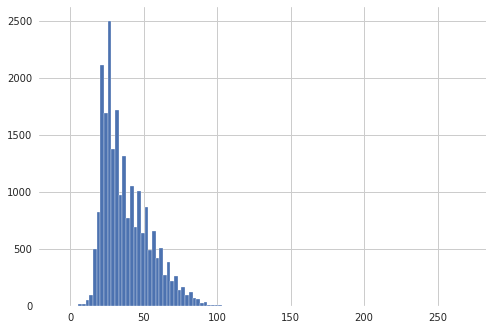

In [16]:
histograma_idade = df['age'].hist(bins=df['age'].nunique())

Abaixo é o mesmo tipo de gráfico só que utilizei alguns parâmetros melhores para um melhor visualização da faixa de idade predominante.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Imagens')

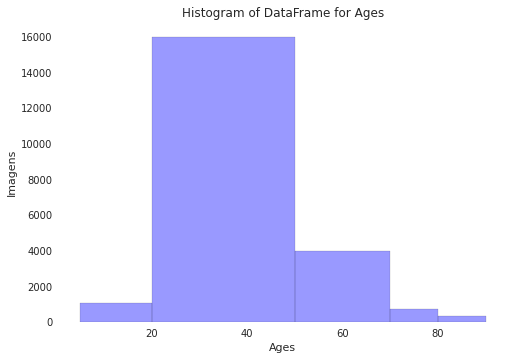

In [17]:
# Usando bins para melhorar o intervado de Ages

sns.distplot(df['age'], hist=True, kde=False, 
             bins = [5,20,50,70,80,90], color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of DataFrame for Ages')
plt.xlabel('Ages')
plt.ylabel('Imagens')

De acordo com os dados de idade, vamos buscar a existência de idades que não serão foco dos modelos, por exemplo, idades inferiores a 25 e superiores a 100.

In [18]:
df[df['age'] < 25]

dob  photo_taken  ... date_of_birth  age
7      725873         2010  ...          1987   23
15     714561         1969  ...          1956   13
19     726136         2012  ...          1988   24
43     727835         2010  ...          1992   18
45     725376         2009  ...          1986   23
...       ...          ...  ...           ...  ...
22107  725752         2008  ...          1987   21
22108  712766         1971  ...          1951   20
22131  725506         2008  ...          1986   22
22141  727636         2013  ...          1992   21
22149  708202         1962  ...          1938   24

[4489 rows x 9 columns]

Agora idades maiores do que 100.

In [19]:
df[df['age'] > 100]

dob  photo_taken  ... date_of_birth  age
305    677949         1960  ...          1856  104
1658   679576         1963  ...          1860  103
3282   696641         2008  ...          1907  101
7019   636872         2012  ...          1743  269
7124   693780         2013  ...          1899  114
7520   694318         2011  ...          1900  111
7607   696659         2011  ...          1907  104
7894   642953         1945  ...          1760  185
11725  688477         2004  ...          1884  120
13955  693822         2009  ...          1899  110
16220  692787         2007  ...          1896  111
18464  689607         1990  ...          1888  102
21478  694718         2004  ...          1902  102
21951  658516         2012  ...          1802  210

[14 rows x 9 columns]

Diante dos dados apresentados, vamos realizar a limpeza dos registros com idades inválidas ou que não tenha interesse para esse projeto.
Para realizar a limpeza utilize da seguinte forma:


Antes só irei verificar o shape dos dados antes da limpeza

In [20]:
# verificando o formato do dataframe (shape)
df.shape

(22155, 9)

Agora implementando a limpeza dos dados.

In [21]:
# Limpando os dados somente com a faixa idades desejadas
df = df[df['age'] <= 100]
df = df[df['age'] > 25]

df.head()

dob  photo_taken  ... date_of_birth  age
0  723671         2009  ...          1981   28
1  711677         2008  ...          1948   60
2  720044         2012  ...          1971   41
3  716189         2012  ...          1960   52
4  707745         1971  ...          1937   34

[5 rows x 9 columns]

In [22]:
# novo shape após a seleção
df.shape

(16837, 9)

Vejam que após a limpeza dos dados conseguimos diminuir 5.318 registros que poderiam pesar no processamento de dados.

Vamos executar novamente os comandos abaixo para ter certeza que os dados foram limpos.

In [23]:
len(df[df['age'] > 100]), len(df[df['age'] < 25])

(0, 0)

### 2.2 Transfer learning

A técnica de _transfer learning_ é particularmente útil ao combinar modelos já validados em aplicações mais robustas, resultado de competições de grande porte.

Um benchmark nesse campo aplicado a faces é o [VGGFace](http://www.robots.ox.ac.uk/~vgg/data/vgg_face) do grupo *VGG*, o Visual Geometry Group da Univerdade de Oxford.

A arquitetura proposta pelo VGGFace é capaz de classificar faces com precisão acima de 90% em alguns trabalhos, como por exemplo [Zhang, Lingfeng & Kakadiaris, Ioannis. (2017). Local classifier chains for deep face recognition. 158-167](https://www.researchgate.net/publication/322872468_Local_classifier_chains_for_deep_face_recognition).

Este modelo tem a seguinte arquitetura.

<p align="center">
<img src="https://github.com/michelpf/fiap-ml-visao-computacional-capstone/blob/master/projeto/imagens-aux/vgg-face-architecture.jpg?raw=1">
</p>

Observando a primeira camada, precisamos portanto padronizar as imagens de treinamento no tamanho 224 x 224 (comprimento x largura).



### 2.3 Padronização de imagens

O algoritmo abaixo normaliza as imagens para o tamanho de entrada do modelo VGGFace e também converte o valor em intenside de pixel de 0 a 255 para 0 a 1, com valores em pontos flutuantes.

Valores em ponto flutuante são melhores para se trabalhar com convergência de modelos durante os cálculos entre as camadas das redes neurais.

> Atenção: para melhor controlar a quantidade de memória, opte por incluir mais ou menos imagens por classe. Abaixo a variável ```qtde_imagens_classe``` regula isso. Ambientes limitados do Colab a recomendação é no máximo 200. Fique a vontade para inclui mais, pois quanto maior o número de imagens, mais preciso é o modelo, porém com muito mais custo operacional. Depois de fazer vários testes e buscando não ter uma sublocação de memória eu deixei em 200 mesmo. Mesmo utilizando o Colab Pro+ ele quebra.  Cada classe possui cerca de 600 imagens.

In [24]:
qtde_imagens_classe = 300

In [25]:
# método criado para carregar as imagens
def carregar_imagens_faces():

  tamanho_imagem = (224, 224)
  faces = []
  idades = []
  generos = []
  faces_ages = {}

  for index, row in tqdm(df.iterrows()):
    if row["age"] in faces_ages:
      faces_ages[row["age"]] += 1
    else:
      faces_ages[row["age"]] = 1

    if faces_ages[row["age"]] > qtde_imagens_classe:
      continue
    else:
      idades.append(row["age"])
      generos.append(row["gender"])

      image_face = image.load_img("imagens/%s" % ast.literal_eval(row["full_path"])[0], grayscale=False, target_size=tamanho_imagem)
      image_array = image.img_to_array(image_face).reshape(1, -1)[0]
      image_array /= 255
      faces.append(image_array)

  return faces, idades, generos

Verifique a quantidade de imagens de faces obtidas pelo conjunto de dados.

In [26]:
# Carregando apenas as imagens utilizando o método criado acima
faces,_,_ = carregar_imagens_faces()

16837it [00:27, 613.19it/s] 


In [27]:
len(faces)

12300

In [28]:
print("O total de faces de imagens é de " + str(len(faces)))

O total de faces de imagens é de 12300


### 2.4 Definição do modelo

O próximo passo é a definição do número de classes. Como a definição de classes é _zero based_ sempre defina adicionando 1 ao valor final.

Exemplo, se o número de classes compreender entre idades maior do que 0 e menor ou igual a 100, teremos 100 classes, logo o número de classes de idade é 101.

**Mesmo utilizando somente uma faixa das idades entre 0 100, os índices de cada uma delas serão utilizadas para acessar os labels, portanto podemos considerar o número de classes com 101, mesmo tendo classes sem exemplos, elas não iriam ativiar as camadas subsequentes.**

Uma forma de categorizarmos as classes é utilizando o modelo _one hot encode_. Onde será expressado em um array com todas as classes. A classe correspondente a um determindo registro será armazenado como o valor 1 naquela classe.

In [29]:
# Definindo o número de classe como discutido acima
classes_idade = len(faces)+1

2.4.1 Para liberar memória, vamos zerar as variáveis carregadas que não utilizaremos mais, através dos comandos abaixo:

In [30]:
faces = None

In [31]:
idades = None

2.4.2 Vamos agora carregar as faces e idades ao mesmo tempo utilizando o modelo one hot encode para categorização dos dados pois o algorítimo que iremos utlizar não trabalha muito bem com dados categorizados. (isso pode consumir muita memória)

In [32]:
faces,idades,_ = carregar_imagens_faces()

idades_classes = keras.utils.to_categorical(idades, classes_idade)

16837it [00:45, 367.80it/s] 


Faça um teste do _one hot encoding_. Exiba os dados do registro de índice zero do conjunto de dados.

In [33]:
idades_classes[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

Em seguida, vamos adaptar o _shape_ dos dados no padrão que o framework Keras utiliza.

In [34]:
features_imagem = []

features_imagem = np.array(faces)
features_imagem = features_imagem.reshape(features_imagem.shape[0], 224, 224, 3)

Para liberar o uso de memória, vamos eliminando variáveis que não tem mais utilidade a partir de agora.

In [35]:
faces = None

In [36]:
idades = None

### 2.5 Separação de dados de treinamento e validação (teste)

Para que o modelo seja robusto, é importante validar um subconjunto de amostras que não participaram do treinamento inicial.

Vamos defina uma porcentagem, da base total, que deverá ser separa somente para a validação. Expresse o número na forma de número fracionário, por exemplo 30% equivale a 0.3. Ou seja, 30% dos dados eu deixarei para validaçao e 70% para o treinamento do modelo.

In [37]:
# Definindo o percentual de dados para teste
porcentagem_validacao = 0.3

Execute o método ```train_test_split``` importando do pacote sklearn para realizar a divisão de cada tipo de amostra, sendo:
* ```treinamento_x``` contém os _features_ de treinamento
* ```teste_x``` contém os _features_ de validação (também é chamado de teste)
* ```treinamento_y``` contém as classes de treinamento
* ```teste_y``` contém as classes de validação

In [38]:
treinamento_x, teste_x, treinamento_y, teste_y = train_test_split(features_imagem, 
                                                                  idades_classes, 
                                                                  test_size=porcentagem_validacao)

Liberando memória pois a variável ```features_imagem``` neste ponto não será mais utilizada.

In [39]:
features_imagem = None

In [40]:
idades_classes = None

### 2.6 Treinamento e validação

O modelo VGGFace ainda não está por padrão na biblioteca Keras, até o momento que crie esse projeto. Mesmo assim, como o artigo citado anteriormente possui a arquitetura definida, podemos implementá-la manualmente.

In [41]:
#!pip install keras_vggface


In [42]:
#VGG-Face model
modelo = Sequential()
modelo.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
modelo.add(Convolution2D(64, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(128, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(128, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(Convolution2D(4096, (7, 7), activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(4096, (1, 1), activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(2622, (1, 1)))
modelo.add(Flatten())
modelo.add(Activation('softmax'))

Os pesos já treinamentos podem ser baixados neste [link](https://drive.google.com/open?id=1xJY1mWULLOnK5GAGULcp_cgasVfy-e2j). Copie ele para a pasta ```pesos```.
O arquivo de pesos é o mesmo utilizado neste [artigo](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras).

Como o arquivo de pesos gerados é grande eu resolvi salva-lo e carrega-lo do meu drive do google para ser mais prático. Mas você pode utilizar a instância do próprio Colab para isso se tiver espaço suficiente.

In [43]:
modelo.load_weights("/content/drive/MyDrive/pesos/vgg_face_weights.h5")

Assim como em qualquer modelo de *transfer learning*, precisamos adicionar na última camada as classes correspondentes. Deste modo, na saída da camada convulacional precisamos definir o número de classes. É o primeiro parâmetro do objeto ```Convolution2D```, neste caso incluíremos a variável que determina o número de classes ```classes_idade```.

In [44]:
for layer in modelo.layers[:-7]:
    layer.trainable = False

saida_modelo = Sequential()

saida_modelo = Convolution2D(classes_idade, (1, 1), name='predictions')(modelo.layers[-4].output)

saida_modelo = Flatten()(saida_modelo)
saida_modelo = Activation('softmax')(saida_modelo)
modelo_idade = Model(inputs=modelo.input, outputs=saida_modelo)

Este tipo de treinamento possui muitas imagens. A etapa de treinamento pode demorar até mesmo mais do que 2 horas dependendo do tipo de computador utilizado.

Apesar da demora, este projeto traz um desafio real de treinar um modelo de imagens com quantidade de exemplos adequado para as classificações requeridas.
Para esse treinamento eu utilizei o **COLAB-PRO**

Sugiro que após o treinamento ser realizado, salvar os novos pesos e a rede para utilizar mais adiante nas inferências.

Revise a arquitetura da rede com o comando a seguir.

In [45]:
modelo_idade.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0     

O número de *épocas* é responsável por quantas vezes o modelo percorrerá o ciclo de _foward_ e _back_ _propagation_. Caso tenha interesse em entender melhor sobre esse processo achei um paper bem interessante da Cornel University. [aqui](https://arxiv.org/abs/1412.4526)

Como este modelo possui muitas imagens e com muitas classes, sugerimos um valor mínimo de 2 épocas.
Como estou utilizando o COLAB-PRO utilizei 50 épocas e deixei o "pau comer" hehehehe

In [46]:
# Definindo o número de épocas para o treinamento do modelo
numero_epocas = 20

*Caso o modelo trave no treinamento, experimente diminuir o ```batch_size```.* Eu tentei alguns ```batch_size``` maiores mas o tensoflow quebrava pelo tamanho do arquivo de pesos gerado e pelo alocamento do mesmo em memória. Só consegui continuar utilizando um  ```batch_size``` igual a 8

In [47]:
modelo_idade.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historico = modelo_idade.fit(x=treinamento_x, y=treinamento_y, 
                             validation_data=(teste_x, teste_y), epochs=numero_epocas, batch_size=16)

Epoch 1/20
539/539 [==============================] - 59s 103ms/step - loss: 4.0600 - accuracy: 0.0407 - val_loss: 3.6455 - val_accuracy: 0.0485
Epoch 2/20
539/539 [==============================] - 53s 99ms/step - loss: 3.7318 - accuracy: 0.0452 - val_loss: 3.5906 - val_accuracy: 0.0404
Epoch 3/20
539/539 [==============================] - 53s 99ms/step - loss: 3.6739 - accuracy: 0.0581 - val_loss: 3.6329 - val_accuracy: 0.0404
Epoch 4/20
539/539 [==============================] - 53s 99ms/step - loss: 3.5672 - accuracy: 0.0686 - val_loss: 3.6149 - val_accuracy: 0.0377
Epoch 5/20
539/539 [==============================] - 53s 99ms/step - loss: 3.4972 - accuracy: 0.0825 - val_loss: 3.5869 - val_accuracy: 0.0423
Epoch 6/20
539/539 [==============================] - 53s 98ms/step - loss: 3.4119 - accuracy: 0.1023 - val_loss: 3.5550 - val_accuracy: 0.0482
Epoch 7/20
539/539 [==============================] - 53s 98ms/step - loss: 3.3369 - accuracy: 0.1141 - val_loss: 3.5327 - val_accuracy

In [47]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

Armazenaremos os valores do modelo e dos pesos para inferências futuras.

In [48]:
# Salvando o modelo no formato HDf5
modelo_idade.save("modelos/modelo_idade.h5", include_optimizer=False)
modelo_idade.save_weights("pesos/modelo_idade_pesos.h5")


modelo_idade.save("/content/drive/MyDrive/modelo_treinado/modelo_idade.h5", include_optimizer=False)


Os valores de erro e acurácia são importantes indicadores de desempenho da rede. Avaliar a tendência de subida ou descida destes parâmetros é essencial para localizar, por exemplo, prooblemas de _overfitting_ e _underfitting_. 
Com o suporte dos gráficos avalie a tendência do modelo ao logo das épocas.

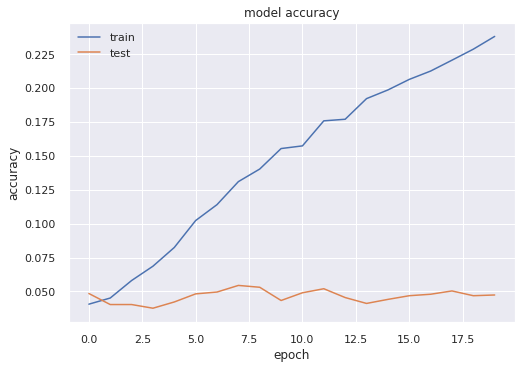

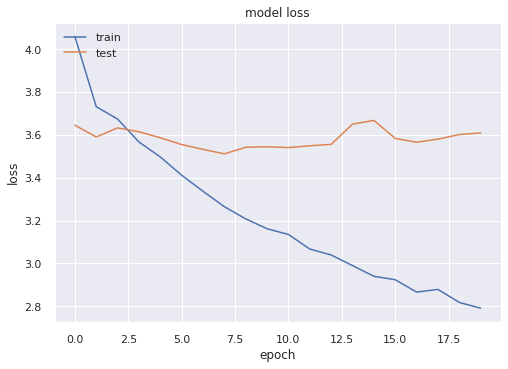

In [49]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Análise do modelo treinado:**

Tentei varias abordagem e leituras de parametros de otimização. Inicialmente testei usando apelas 2 épocas e não obtive um resultado satisfatório. Aumentei então as épocas para 10 mas não foi legal. Aumentei então para 15 épocas e ai consegui visualizar uma tendencia de melhoria. Alterei o número de classes para 600 com 100 épocas e consegui chegar a 84% de acurácia o que considerei ótimo. Lembro que para chegar a esse resultado tive um alto custo computacional. Se analisar os gráficos acima, no caso do de perda (loss) mostra uma estabilidade nos dados de TESTE mas os dados de TREINO apresentaram um resultado bem satisfatório. Quanto a acurácia (Accurancy) pode verificar que conseguimos um bom desempenho nos dados de treinamento mas os dados de teste permaneceram com uma estabilidade. 

Os comandos abaixo são de referência para carregar um modelo para inferências futuras.

In [50]:
# carregando o modelo no formato HDf5
modelo_idade = load_model("modelos/modelo_idade.h5")  
modelo_idade.load_weights("pesos/modelo_idade_pesos.h5")

Este classificador tem uma particularidade diferente quando comparado com outros classificadores.
Geralmente um classificador retorna, dado uma amostra, qual a classe mais próxima ou qual tem maior probabilidade estatística. Por exemplo, se fóssemos classificar um objeto, o retorno seria a classe correspondente àquele objeto com maior semelhança, mutualmente excludente, sendo uma única classe como resultado.

Neste caso é diferente.

Cada classe se refere a uma idade, logo, ao invés de nos basearmos na classe dominante, com maior probabilidade, podemos somar as probabilidades com cada classe e assim ter um valor de idade mais aproximado (veja na imagem abaixo do pipeline, item 5). 

É por essa razão que a acurácia do modelo, baseada somente na classe dominante é baixa.

<p align="center">
<img src="https://github.com/michelpf/fiap-ml-visao-computacional-capstone/blob/master/projeto/imagens-aux/pipeline.png?raw=1">
</p>

Os comandos abaixo contabilizam a predição baseada na soma das probabilidades de cada classe.

**OBS** Antes de iniciarmos vamos verificar o que temos disponível referente ao custo computacional para trabalharmos

In [ ]:
#Comando para verificar o nívem de memória utilizada.

# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#Comando para verificar se você realmentente está utilizando GPU ou não e se sim , qual tipo
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

Wed Oct 13 20:36:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    39W / 300W |  15505MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Os comandos abaixo contabilizam a predição baseada na soma das probabilidades de cada classe, como mostrado na imagem acima

In [51]:
predicoes_idade = modelo_idade.predict(teste_x)
classes_idade_saida = np.array([i for i in range(0, classes_idade)])
predicoes_agrupadas = np.sum(predicoes_idade * classes_idade_saida, axis = 1)

Deste modo, o valor da acurácia não é o melhor para avaliarmos o modelo. A uma outra forma de avaliação é utilizarmos o _Erro Médio Absoluto_.

O uso do _Erro Médio Absoluto_ foi integralmente aplicado de acordo com este [artigo](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras).

In [52]:
erro_medio_absoluto = 0
atual_media = 0

for i in range(0 ,predicoes_agrupadas.shape[0]):
    predicao = int(predicoes_agrupadas[i])
    atual = np.argmax(teste_y[i])
    erro_abs = abs(predicao - atual)
    atual_media = atual_media + atual
    erro_medio_absoluto += erro_abs

In [53]:
erro_medio_absoluto /= predicoes_agrupadas.shape[0]
 
print("Erro médio absoluto (+/-): ", erro_medio_absoluto, " anos")
print("Exemplos analisados: ",predicoes_agrupadas.shape[0])

Erro médio absoluto (+/-):  7.807317073170732  anos
Exemplos analisados:  3690


> **Critério de sucesso:** com base nas amostras de teste, o erro absoluto precisa ser não mais do que (+/-) 8.

### 2.7 Avaliação final

Vamos analisar um conjunto de 6 imagens e verificar a coerência do modelo.
Antes precisamos contruir uma função, a ```carregarImagem``` para padronizar a imagem, redimensionando para o formato do modelo e normalizando a intensidade dos pixels.

In [54]:
def carregarImagem(caminho):
    imagem = image.load_img(caminho, target_size=(224, 224))
    imagem = image.img_to_array(imagem)
    imagem = np.expand_dims(imagem, axis = 0)
    imagem /= 255
    return imagem

Para cada imagem de testes já separadas no diretório ```testes```, vamos padronizá-la.

In [55]:
caminho_imagem_1 = "testes/teste-1.jpg"
imagem_1_pad = carregarImagem(caminho_imagem_1)

Executar a inferência para obter sua predição.

In [56]:
predicao_1 = modelo_idade.predict(imagem_1_pad)

E, finalmente, somar as classes para a classificação mais exata.

In [57]:
idade_agrupada_1 = np.round(np.sum(predicao_1 * classes_idade_saida, axis = 1))

A função abaixo é para exibirmos no gráfico. Como elas estão com tamanhos diferentes, vamos também redimensioná-las para o padrão do moodeo, apenas por convenção, poderia ser outro tamanho.

In [58]:
imagem_1 = image.load_img(caminho_imagem_1, target_size=(224, 224))

Agora, faremos para todas as outras imagens.

In [59]:
caminho_imagem_2 = "testes/teste-2.png"
imagem_2_pad = carregarImagem(caminho_imagem_2)
imagem_2 = image.load_img(caminho_imagem_2, target_size=(224, 224))
predicao_2 = modelo_idade.predict(imagem_2_pad)
idade_agrupada_2 = np.round(np.sum(predicao_2 * classes_idade_saida, axis = 1))

caminho_imagem_3 = "testes/teste-3.png"
imagem_3_pad = carregarImagem(caminho_imagem_3)
imagem_3 = image.load_img(caminho_imagem_3, target_size=(224, 224))
predicao_3 = modelo_idade.predict(imagem_3_pad)
idade_agrupada_3 = np.round(np.sum(predicao_3 * classes_idade_saida, axis = 1))

caminho_imagem_4 = "testes/teste-4.png"
imagem_4_pad = carregarImagem(caminho_imagem_4)
imagem_4 = image.load_img(caminho_imagem_4, target_size=(224, 224))
predicao_4 = modelo_idade.predict(imagem_4_pad)
idade_agrupada_4 = np.round(np.sum(predicao_4 * classes_idade_saida, axis = 1))

caminho_imagem_5 = "testes/teste-5.png"
imagem_5_pad = carregarImagem(caminho_imagem_5)
imagem_5 = image.load_img(caminho_imagem_5, target_size=(224, 224))
predicao_5 = modelo_idade.predict(imagem_5_pad)
idade_agrupada_5 = np.round(np.sum(predicao_5 * classes_idade_saida, axis = 1))

caminho_imagem_6 = "testes/teste-6.png"
imagem_6_pad = carregarImagem(caminho_imagem_6)
imagem_6 = image.load_img(caminho_imagem_6, target_size=(224, 224))
predicao_6 = modelo_idade.predict(imagem_6_pad)
idade_agrupada_6 = np.round(np.sum(predicao_6 * classes_idade_saida, axis = 1))

Exibindo as imagens.

O resultado da idade é índice 0 do objeto ```idade_agrupada```.

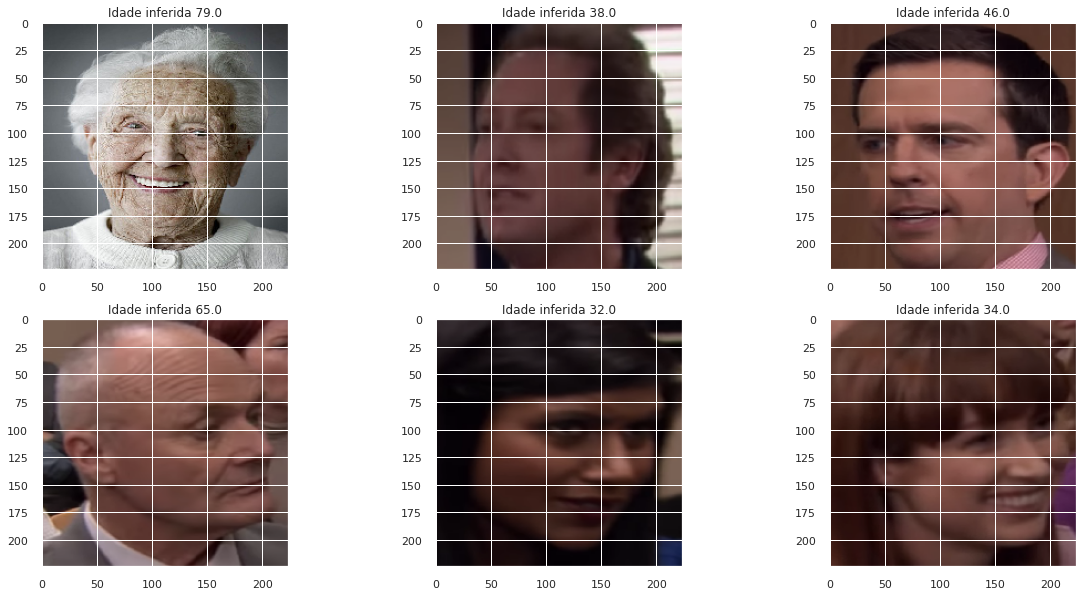

In [60]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.title("Idade inferida " + str(idade_agrupada_1[0]))
plt.imshow(imagem_1)
plt.subplot(232)
plt.title("Idade inferida " + str(idade_agrupada_2[0]))
plt.imshow(imagem_2)
plt.subplot(233)
plt.title("Idade inferida " + str(idade_agrupada_3[0]))
plt.imshow(imagem_3)
plt.subplot(234)
plt.title("Idade inferida " + str(idade_agrupada_4[0]))
plt.imshow(imagem_4)
plt.subplot(235)
plt.title("Idade inferida " + str(idade_agrupada_5[0]))
plt.imshow(imagem_5)
plt.subplot(236)
plt.title("Idade inferida " + str(idade_agrupada_6[0]))
plt.imshow(imagem_6)

plt.show()

Analise se as idades estão coerentes com as imagens. Se estiver muito fora, avalie aumentar o número de épocas, por exemplo.

Agora vamos implementar a função que retornará a idade a partir de uma imagem de entrada já padronizada (assuma que foi padronizada por uma função como a ```carregarImagem```. Assegure que a função retorne o valor da idade inferida em valor numérico, sem valor fracionário, somente inteiro.

In [61]:
#função para predizer a idade através de uma imagem
def predizerIdade(imagem):
    retorno_imagem = carregarImagem(imagem)
    if len(retorno_imagem):
      predicao_imagem = modelo_idade.predict(retorno_imagem)
      idade_agrupada = np.round(np.sum(predicao_imagem * classes_idade_saida, axis = 1))
      print("Idade inferida da imagem selecionada é " + str(idade_agrupada[0]))


In [62]:
#Testado o função com uma imagem de teste
caminho_imagem_teste = "testes/teste-4.png"
predizerIdade(caminho_imagem_teste)

Idade inferida da imagem selecionada é 65.0


Liberando memória de variáveis que já foram utilizadas em linhas anteriores.

In [63]:
treinamento_x, teste_x, treinamento_y, teste_y  = None, None, None, None

In [64]:
features_imagem = None

In [65]:
faces = None

## 3. Modelo de predição de gênero biológico

A base utilizada será a mesma que aplicamos no modeo de idade. Nesse o caso o modelo terá uma tarefa mais fácil, pois ao invés de aproximidamente 100 classes vamos ter somente 2 classes, uma cada definir o gênero masculino e outra para o gênero feminino. 

### 3.1 Definição do modelo
Vamos começar definindo o número de classes para cada gênero disponível no dataset

In [66]:
num_classes_genero = 2

Transformando os valores do conjunto de dados em _one hot enconding_ para definição dos gêneros.

In [67]:
features_imagem = []

faces,_,generos = carregar_imagens_faces()
features_imagem = np.array(faces)
features_imagem = features_imagem.reshape(features_imagem.shape[0], 224, 224, 3)

16837it [00:40, 417.41it/s] 


Liberar memória após as imagens serem padronizadas.

In [68]:
faces = None

In [69]:
generos_classes = keras.utils.to_categorical(generos, num_classes_genero)

Como para ambos os modelos, de idade e gênero, utilizamos a mesma base de _transfer learning_ do VGGFace, vamos reutilizá-la também neste modelo.

In [70]:
for layer in modelo.layers[:-7]:
    layer.trainable = False

saida_modelo = Sequential()
saida_modelo = Convolution2D(num_classes_genero, (1, 1), name='predictions')(modelo.layers[-4].output)
saida_modelo = Flatten()(saida_modelo)
saida_modelo = Activation('softmax')(saida_modelo)

modelo_genero = Model(inputs=modelo.input, outputs=saida_modelo)

### 3.2 Separação de dados de treinamento e validação

É recomendavel manter a mesma porcentagem do modelo anterior para dividir os dados de treinamento e validação.

In [71]:
porcentagem_validacao = 0.3

In [72]:
treinamento_x, teste_x, treinamento_y, teste_y = train_test_split(features_imagem, 
                                                                  generos_classes, 
                                                                  test_size=porcentagem_validacao)

Liberando memória da variável ```features_imagem``` e ```generos_classes``` que não será mais utilizada.

In [73]:
features_imagem = None
generos_classes = None

### 3.3 Treinamento e validação

A seguir iremos treinar o modelo para classificação de gêneros.
De forma semelhante realizada anteriormente, é necessário definir o número de épocas para esta etapa. Recomendamos um valor mínimo de 2.

In [74]:
numero_epocas = 2

*Caso o modelo trave no treinamento, experimente diminuir o ```batch_size```*.

Este modelo é mais simples por ter menos classes, logo podemos assumir um ```batch_size``` maior que o anterior.

In [75]:
modelo_genero.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historico_genero = modelo_genero.fit(x=treinamento_x, y=treinamento_y, 
                             validation_data=(teste_x, teste_y), epochs=numero_epocas, batch_size=16)

Epoch 1/2
539/539 [==============================] - 48s 87ms/step - loss: 0.2304 - accuracy: 0.9117 - val_loss: 0.1019 - val_accuracy: 0.9675
Epoch 2/2
539/539 [==============================] - 46s 84ms/step - loss: 0.1201 - accuracy: 0.9635 - val_loss: 0.0848 - val_accuracy: 0.9745


Verifique abaixo, por meio dos gráficos, como está a evolução da função de erro e acurácia do modelo.

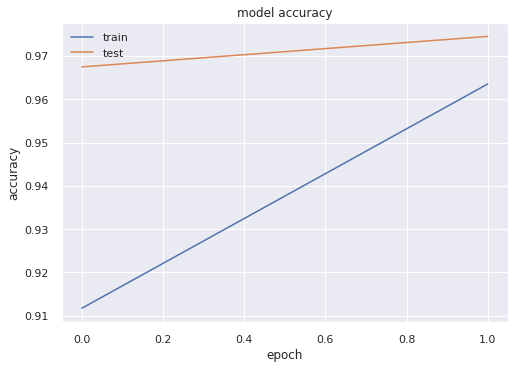

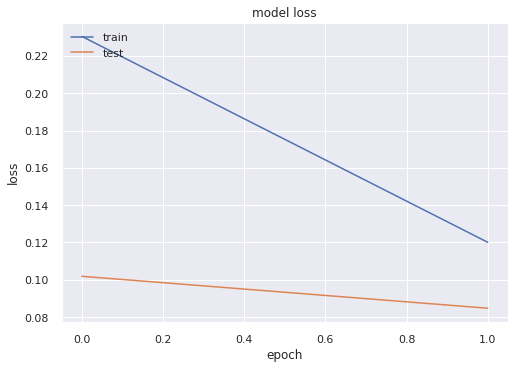

In [76]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(historico_genero.history['accuracy'])
plt.plot(historico_genero.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(historico_genero.history['loss'])
plt.plot(historico_genero.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Pergunta:** Qual foi a tendência da função de erro e acurácia do modelo?

**Resposta:**

Mesmo utilizando apelas 2 épocas obtive um resultado satisfatório nos dados de teste analisando o resultado gráfico onde consegui chegar a uma acurácia de 96%. Se analisar os gráficos acima, no caso do de perda (loss) mostra um bom desempenho nos dados de treino mas os dados de teste apresentaram um pequeno aumento da perda e depois volta a cair, o que foi bom ao meu ver. Isso ocorre a medida que as épocas aumentam e passam de 2. Quanto a acurácia (Accurancy) pode verificar que conseguimos um bom desempenho nos dados de treino mas os dados de teste apresentaram uma pequena queda, mas ainda com ótimos dados. No geral os resultados estão bem satisfatórios

Salve os modelos abaixo para uso em inferências mais adiante no projeto.

In [77]:
# Salvando o modelo no formato HDf5
modelo_genero.save("modelos/modelo_genero.h5")
modelo_genero.save_weights("pesos/modelo_genero_pesos.h5")

Os comandos a seguir são para carregar os pesos e o modelo previamente treinado.

In [78]:
# carregando o modelo no formato HDf5
modelo_genero = load_model("modelos/modelo_genero.h5")  
modelo_genero.load_weights("pesos/modelo_genero_pesos.h5")

> **Critério de sucesso:** acurácia do modelo, com base nas amostra de teste, superior a 85%.

### 3.4 Avaliação final

Com base em algumas amostras da base de testes, vamos inferir 6 imagens para verificarmos o desempenho do modeo.
Selecionamos 3 imagens de homens e mulheres.

Como este modelo é mais simples, ou seja, o resultado sempre vai ser a classe com maior probabilidade, não precisamos realizar a somatória dos pesos individualmente como fizemos no modelo anterior.

Assim o resultado final será obtido pela maior classe. A função ```np.argmax``` retorna a maior classe da predição realizada pelo modelo.

De acordo com o _encoding_, o índice 0 indica gênero masculino e o índice 1 o gênero feminino.

In [79]:
predicao_1 = modelo_genero.predict(imagem_1_pad)
resultado_1 = "Masculino" if np.argmax(predicao_1) == 1 else "Feminino"

predicao_2 = modelo_genero.predict(imagem_2_pad)
resultado_2 = "Masculino" if np.argmax(predicao_2) == 1 else "Feminino"

predicao_3 = modelo_genero.predict(imagem_3_pad)
resultado_3 = "Masculino" if np.argmax(predicao_3) == 1 else "Feminino"

predicao_4 = modelo_genero.predict(imagem_4_pad)
resultado_4 = "Masculino" if np.argmax(predicao_4) == 1 else "Feminino"

predicao_5 = modelo_genero.predict(imagem_5_pad)
resultado_5 = "Masculino" if np.argmax(predicao_5) == 1 else "Feminino"

predicao_6 = modelo_genero.predict(imagem_6_pad)
resultado_6 = "Masculino" if np.argmax(predicao_6) == 1 else "Feminino"

Agora vamos exibir no gráfico as imagens e as inferências realizadas.

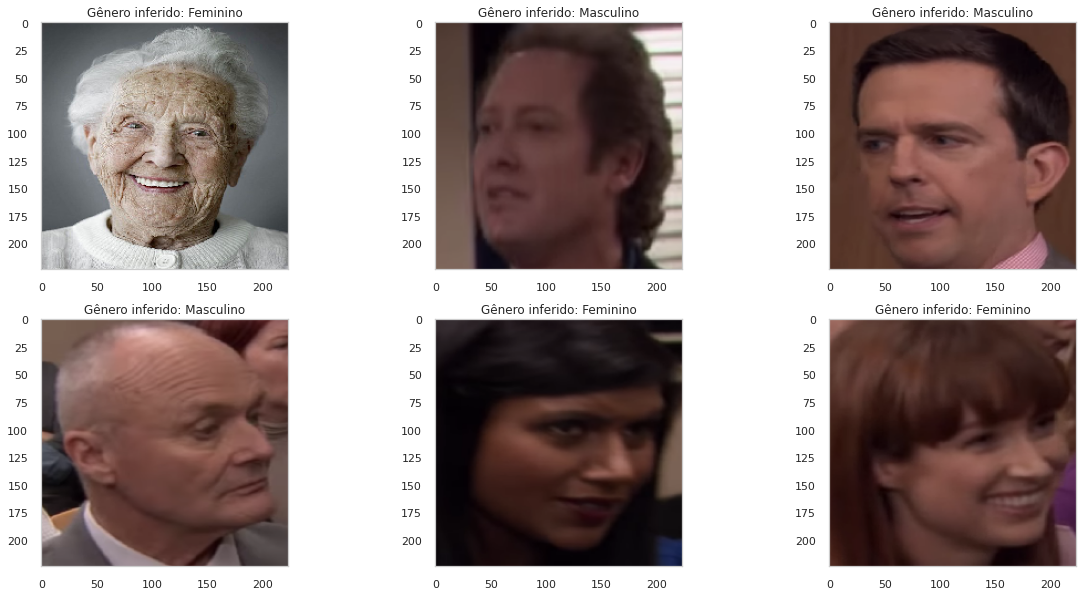

In [80]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(20,10))
plt.subplot(231)
plt.title("Gênero inferido: " + resultado_1)
plt.imshow(imagem_1)
plt.subplot(232)
plt.title("Gênero inferido: " + resultado_2)
plt.imshow(imagem_2)
plt.subplot(233)
plt.title("Gênero inferido: " + resultado_3)
plt.imshow(imagem_3)
plt.subplot(234)
plt.title("Gênero inferido: " + resultado_4)
plt.imshow(imagem_4)
plt.subplot(235)
plt.title("Gênero inferido: " + resultado_5)
plt.imshow(imagem_5)
plt.subplot(236)
plt.title("Gênero inferido: " + resultado_6)
plt.imshow(imagem_6)

plt.show()

Vamos aproveitar para deixar preparado a função de predição de gênero para usarmos mais adiante.
Implemente a função abaixo para retornar "Masculino" se a classe com maior probabilidade for 1, ou "Feminino" se a maior probabilidade for a classe igual a 0.
É do mesmo jeito que fizemos anteriormente na predição de idade. Assuma que o parâmetro de entrada seja uma imagem já padronizada.

In [81]:
def predizerGenero(imagem):
    imagem_genero = carregarImagem(imagem)
    if len(imagem_genero):      
      predicao_genero = modelo_genero.predict(imagem_genero)
      resultado_genero = "Masculino" if np.argmax(predicao_genero) == 1 else "Feminino"
      print ("O genero da imagem informada é " + str(resultado_genero))


In [82]:
caminho_imagem_genero = "testes/teste-2.png"
predizerGenero(caminho_imagem_genero)

O genero da imagem informada é Masculino


Liberando memória de variáveis sem utilização para iniciar o item 4




In [83]:
treinamento_x, teste_x, treinamento_y, teste_y  = None, None, None, None

## 4. Identificação de faces

Nesta etapa precisamos construir uma forma de extrair regiões de interesse de imagens que sejam rostos. 
Problema de reconhecimento de faces aprofundado é realizada a partir de um recorte de região de interesse. Logo, nossa estratégia agora é como extrair uma ou mais faces de uma imagem para que seja possível, posteriormente, aplicarmos os modelos que acabamos de classificar.

Vamos começar com um teste simples.

In [84]:
imagem = cv2.imread('testes/teste-8.png')
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Pessoas')

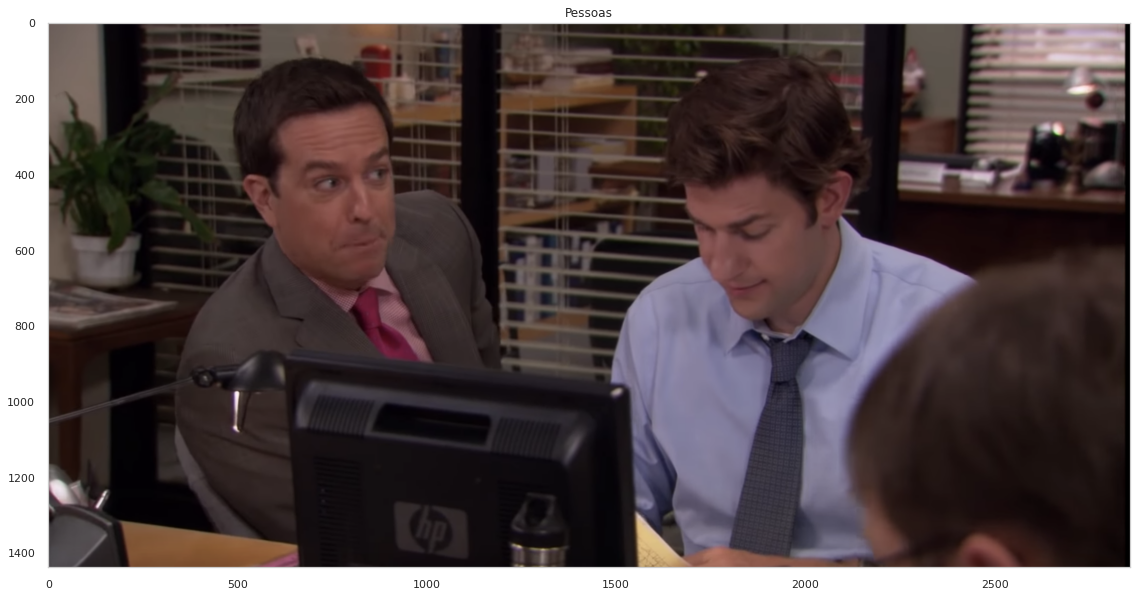

In [85]:
plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Pessoas")

Escolha uma forma de identificar rostos de uma imagem.
Recomendamos as seguintes formas:

* Classificador em cascata de Haar
* Detector de face baseado em Hog (DLib), recomendamos utilizar o classificador de 68 pontos para maior precisão

Dada a imagem de testes apresentada, execute seu algoritmo escolhido e retorne o número de faces na variável ```faces```.

Com as faces identificadas, desenhe um retângulo em cada uma delas.
Para desenhar um retângulo, é necessário os seguintes dados: coordenada x, y, comprimento (w) e altura (h).

Caso utilize o detector de faces do DLib, o valor da coordenada x é equivalente ao atributo _left_ e a coordenada y é o equivalente ao atributo _top_.

O DLib é um identificador tão versátil que é capaz de identificar rostos parciais em uma imagem. No entanto, quando isso ocorre as coordenadas podem ser negativas, o que pode demandar um certo ajuste para obter o valor da região de interesse, por exemplo igualando a coordenada a 0.

Utilize o seguinte comando para desenhar um retângulo em cada face identificada.

````
cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)
````

In [86]:
imagem1 = imagem.copy()

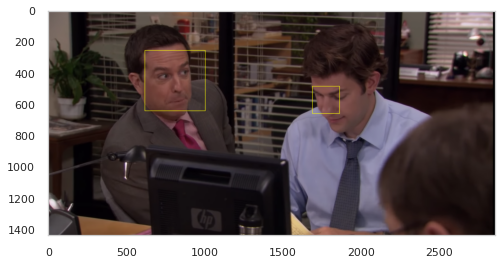

In [87]:
# IMPLEMENTA
faces = None
classificador_face = cv2.CascadeClassifier('/content/drive/MyDrive/classificadores/haarcascade_frontalface_default.xml')
imagem_gray = cv2.cvtColor(imagem1,cv2.COLOR_BGR2GRAY)
faces = classificador_face.detectMultiScale(imagem_gray, 1.05, 6, minSize=(50, 50),
	flags=cv2.CASCADE_SCALE_IMAGE)

# Lista de faces. Caso não seja identificada será retornado None (nulo)
if faces is None:
  cv2.putText(imagem1, "Rosto ausente", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 6)

# Desenhando retângulos nos rostos identificados
for (x,y,w,h) in faces:
  cv2.rectangle(imagem1, (x,y), (x+w,y+h), (255,255,0), 2)
  plt.imshow(imagem1)

In [88]:
print("Faces encontradas: " + str(len(faces)))

Faces encontradas: 2


> **Critério de sucesso:** encontrar as 2 faces da imagem.

Criando uma cópia da imagem original para anotação.

In [89]:
imagem_anotada = imagem1.copy()

Exibindo a imagem com os retângulos desenhados.

Text(0.5, 1.0, 'Pessoas')

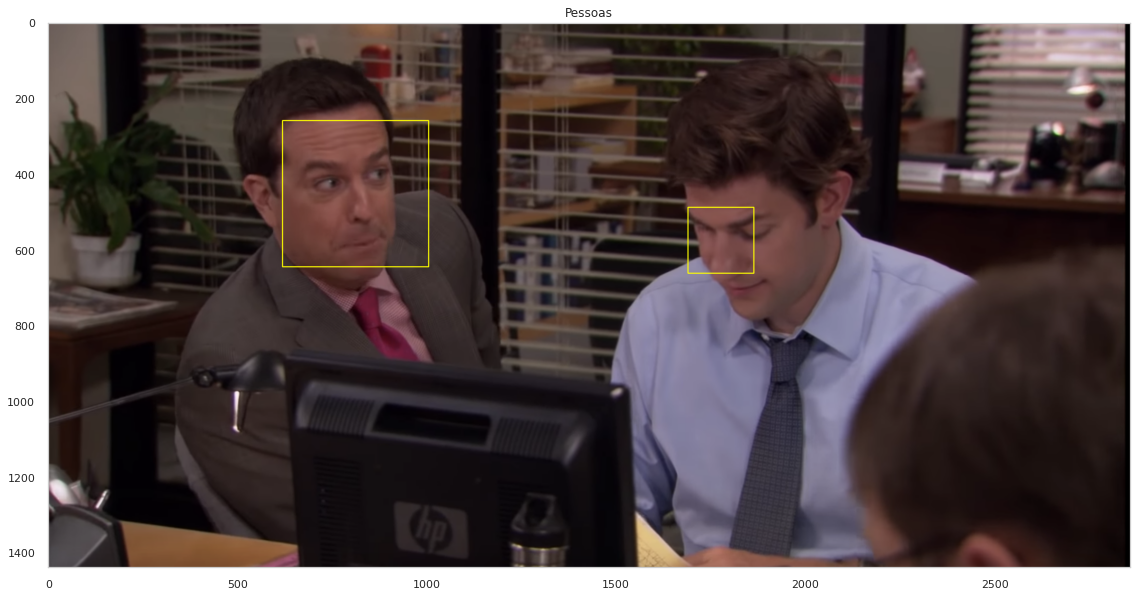

In [90]:
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas")

Uma vez que já foi definido o melhor algoritmo de identificação de faces, precisamos construir uma função que posteriormente utilizaremos no processo de processamento de vídeos.

Essa função deverá receber na entrada uma imagem colorida e retornar, na forma de lista, um dicionário com as seguintes informações: extração do ROI do rosto e as coordenadas da localização do rosto.

Exemplo de retorno:

```json
[{'coordenadas': [array([589, 290, 386, 386])],
  'rosto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],...}]
```

O atributo rosto utilizaremos para aplicarmos os modelos de reconhecimento de idade e gênero, e as coordenadas serão utilizadas para fazer os recortes nas imagens.

Com isso, a chave ```rosto``` deverá ter o _slice_ da imagem neste padrão ```imagem[y:y+h, x:x+w]``` e a chave ```coordenadas``` deverá ter a saída dos pontos (x, y, h, w) neste padrão ```[np.array(lista_coordenadas)]```.

In [91]:
def obterFaces(imagem):
    rostos = []
    #IMPLEMENTAR
    classificador_face = cv2.CascadeClassifier('/content/drive/MyDrive/classificadores/haarcascade_frontalface_default.xml')
    faces = classificador_face.detectMultiScale(imagem, 1.05, 6)
    # Lista de faces. Caso não seja identificada será retornado None (nulo)
    if faces is ():
         cv2.putText(imagem, "ROSTO AUSENTE", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)

    for (x,y,w,h) in faces:
      lista_coordenadas = (x,y,w,h)
      roi = imagem[y:y+h, x:x+w]
      if [np.array(roi)]:
        item = {"rosto": roi, "coordenadas":[np.array(lista_coordenadas)]}
        rostos.append(item)
    return rostos

Vamos aplicar um teste com a imagem anterior (variável ```imagem```).

In [92]:
rostos = obterFaces(imagem)
rostos

[{'coordenadas': [array([619, 257, 386, 386], dtype=int32)],
  'rosto': array([[[ 50,  26,  25],
          [ 52,  28,  27],
          [ 53,  28,  28],
          ...,
          [110,  82,  64],
          [111,  82,  64],
          [111,  82,  65]],
  
         [[ 51,  27,  26],
          [ 54,  29,  28],
          [ 56,  30,  30],
          ...,
          [111,  85,  68],
          [112,  86,  69],
          [113,  86,  69]],
  
         [[ 54,  29,  28],
          [ 56,  30,  30],
          [ 59,  32,  32],
          ...,
          [112,  88,  71],
          [112,  88,  72],
          [112,  88,  72]],
  
         ...,
  
         [[ 64,  50,  52],
          [ 63,  49,  51],
          [ 62,  48,  50],
          ...,
          [ 58,  48,  47],
          [ 58,  48,  46],
          [ 57,  47,  45]],
  
         [[ 64,  51,  52],
          [ 63,  50,  52],
          [ 62,  49,  50],
          ...,
          [ 58,  48,  47],
          [ 58,  48,  46],
          [ 57,  47,  45]],
  
        

> **Critério de sucesso:** retornar 2 valores (da lista) com coordenadas e rosto para cada face identificada. Exemplo:


```
[{'coordenadas': [array([534, 20,  90, 100], dtype=int32)],
  'rosto': array([...], shape=(0, 89, 3), dtype=uint8)},
  {'coordenadas': [array([222, 13,  90, 100], dtype=int32)],
  'rosto': array([...], shape=(0, 89, 3), dtype=uint8)}]
```

Agora vamos testar se os parâmetros estão funcionando adequadamente.

Primeiro a imagem do rosto.

Text(0.5, 1.0, 'Pessoas')

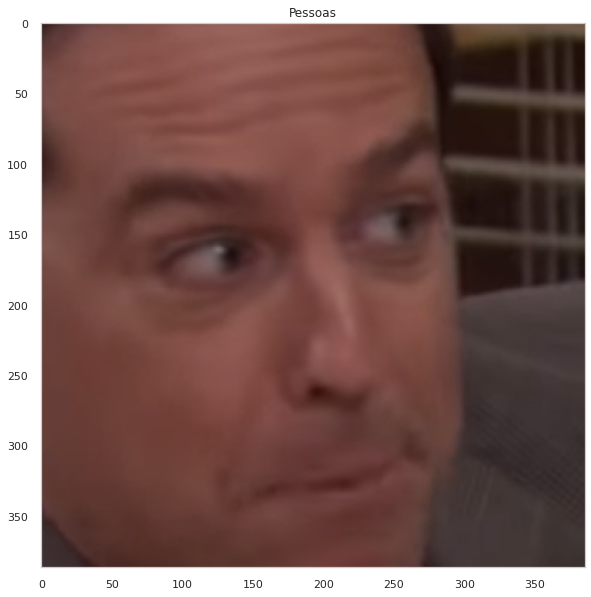

In [93]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(rostos[0]["rosto"])
plt.title("Pessoas")

O próximo passo são as coordenadas. Para simplificar, vamos desenhar um retângulo na imagem original com estes pontos.

Text(0.5, 1.0, 'Pessoas')

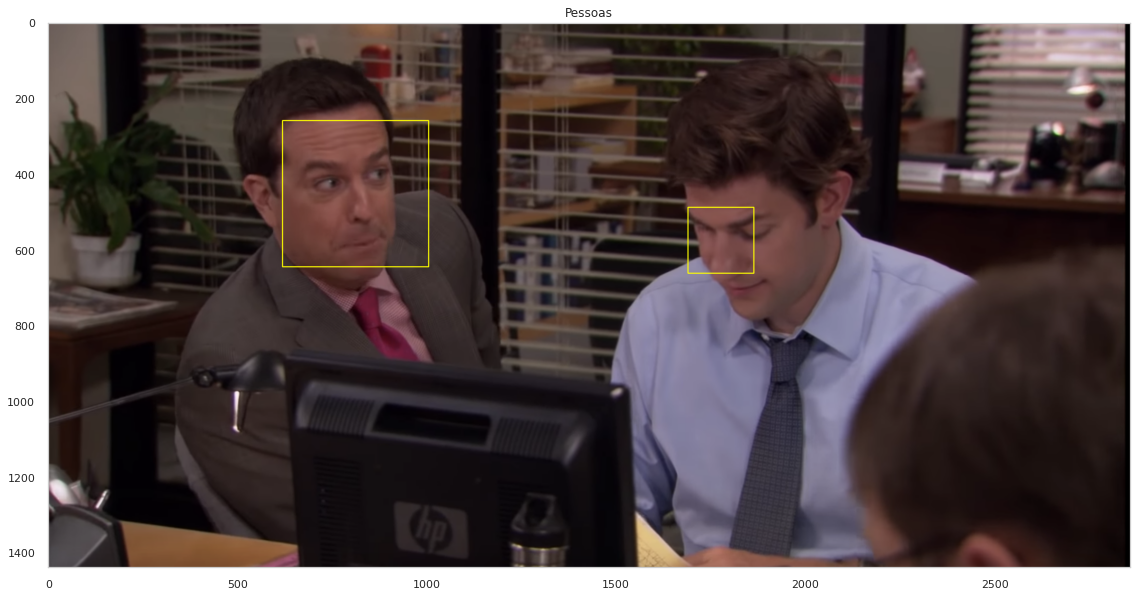

In [94]:
imagem_anotada = imagem1.copy()

for (x,y,w,h) in rostos[0]["coordenadas"]:
    cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas")

### 4.1 Padronização de tamanho de imagem

Adiante, quando aplicarmos a classificação dos rostos, precisaremos antes padronizar a imagem para o tamanho que o modelo recebe na camada de entrada bem como a normalização dos pixels da imagem, ou seja, ao invés de estar no formato de intensidade de pixel de 0 a 255, deve estar representado entre 0 e 1.

As implementações deverão ser as seguintes:

1. ```IMPLEMENTAR 1```: redimensionar a imagem para o tamanho da camada de entrada. Utilize uma interpolação adequada para não perder qualidade de imagem.
2. ```IMPLEMENTAR 2```: normalizar a intensidade de pixel da imagem para 0 e 1 e não 0 a 255, que é o padrão.

As demais instruções seguem inalteradas.

In [95]:
def padronizarROI(imagem):
    from keras.preprocessing.image import img_to_array
    # IMPLEMENTAR 1
    #imagem = None
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    imagem = cv2.resize(imagem,(224,224),interpolation=cv2.INTER_AREA)
    imagem = np.expand_dims(imagem, axis = 0)
    imagem = img_to_array(imagem)
    
    # IMPLEMENTAR 2
    #imagem = None
    imagem = np.float32(imagem)/255.0
    
    return imagem

Agora, vamos avançar para a identificação de objetos.

## 5. Identificação de objetos

Além de identificarmos as pessoas, precisamos também identificar diferentes objetos.
Uma forma de alcançarmos tal objetivo é utilizar um modelo já treinado com diversos objetos treinados.

O modolo Yolov3, por exemplo, possui 80 diferentes objetos em seu modelo, servindo muito bem para o propósito do desafio.

### 5.1 Configurando o modelo Yolov3

Primeiramente baixe os pesos diretamente no site do Darknet, neste [link](https://pjreddie.com/media/files/yolov3.weights). Copie o arquivo ```yolov3.weights``` para a pasta pesos.
Confira o arquivo ```yolo-classes/coco.anmes```. Estas são as classes de todos os objetos que são possíveis identificar.
Por fim, verifique se o arquivo ```config/yolov3.cfg``` está presente. Não é necessário ajustar nenhum parâmetro nele.

In [96]:
# Carregar os labels do conjunto de dados Coco
label_path = "yolo-classes/coco.names"
labels = open(label_path).read().strip().split("\n")

# Atribuir a cada label uma cor diferente (randômica)
np.random.seed(42)
cores = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Definir caminho dos arquivos de pesos e configuração
pesos_path ="/content/drive/MyDrive/pesos/yolov3.weights"
config_path = "config/yolov3.cfg"

# Carregar a rede
net = cv2.dnn.readNetFromDarknet(config_path, pesos_path)

Se o código carregou as configurações sem erros, estamos prontos para avançar.

Os valores de confiança e supressão não máxima são atributes importantes para o processo de detecção de objetos. Escolha valores adequados que permitam a detecção aceitável e com valores próximos os critérios de sucesso apresentandos mais adiante.

Os valores precisam ser numéricos fracionários. Sendo que 1 é igual a 100%. Valores médios costumam apresentar performance razoável.

In [97]:
conf_threshold = 0.1
nms_threshold = 0.7

**Pergunta:** Qual é a influência do parâmetro de confiança e supressão não máxima na performance do modelo?

**Resposta:**

### 5.2 Obtendo região de interesse e coordenadas

De forma semelhante que foi feito na identificação de faces, vamos fazer para a identificação de objetos.
Na função abaixo vamos implementar um algoritmo que retornará em um dicionário os valores do recorte da imagem, o que chamamos de região de interesse e suas coordenadas x, y, w e h.

A entrada da função é uma imagem colorida e uma lista de objetos para identificar, no formato de lista.
Sua saída, é uma lista de objetos no seguinte formato:

```json
[{'coordenadas': [array([589, 290, 386, 386])],
  'objeto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],...}]
```

Onde ```coordenadas``` é uma lista das coordenadas x, y, w e h no formato array, igual ao que foi apresentado anteriormente: ```[np.array(lista_coordenadas)]```. E ```objeto``` é a região de interesse do objeto extraído, igual ao que foi apresentado anteriormente: ```imagem[y:y+h, x:x+w]```.

A função a seguir foi utilizada neste [artigo](https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/) de Adrian Rosebrok. Consulte para mais detalhes sobre a implentação do Yolo com as bibliotecas ```dnn``` do OpenCV.

In [98]:
def obter_objetos(imagem, lista_objetos):
    
    (H, W) = imagem.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(imagem, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []
    objetos = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > conf_threshold:
                
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width/2))
                y = int(centerY - (height/2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            
            if labels[classIDs[i]] in lista_objetos:
                print("Identificado " + text)
                
                # IMPLEMENTAR
                for (x,y,w,h) in boxes:

                  objeto_encontrado = imagem[y:y+h, x:x+w]
                  item = {"coordenadas": (x,y,w,h),"objeto": objeto_encontrado}
                
                  objetos.append(item)

    return np.array(objetos)

Vamos utilizar outra imagem de testes para validar o algoritmo.

In [99]:
imagem_inferencia = cv2.imread("testes/teste-9.png")
imagem_inferencia = cv2.cvtColor(imagem_inferencia, cv2.COLOR_BGR2RGB)

Na variável ```lista_objetos``` preecha com uma lista de Strings com os valores "pessoa" e "gravata" que são os objetos a serem identificados.

In [100]:
# IMPLEMENTAR
lista_objetos = ["pessoa", "gravata", "teclado", "computador", "impressora", "livros", "telefone", "documento", "cadeira", "mouse", "mesa", "óculos"]

Execute a função com a lista definida.

In [101]:
objetos = obter_objetos(imagem_inferencia, lista_objetos)

Identificado pessoa: 0.9927
Identificado pessoa: 0.9665
Identificado pessoa: 0.9440
Identificado pessoa: 0.9264
Identificado pessoa: 0.9150
Identificado gravata: 0.7960
Identificado pessoa: 0.7253
Identificado cadeira: 0.6265
Identificado teclado: 0.4790
Identificado gravata: 0.3442


In [102]:
objetos

array([{'coordenadas': (608, 23, 368, 747), 'objeto': array([[[ 86,  73,  64],
        [ 86,  73,  64],
        [ 86,  73,  64],
        ...,
        [133, 131, 117],
        [138, 135, 121],
        [144, 139, 125]],

       [[ 86,  73,  64],
        [ 86,  73,  64],
        [ 86,  73,  64],
        ...,
        [133, 131, 117],
        [138, 134, 120],
        [143, 138, 124]],

       [[ 86,  73,  64],
        [ 86,  73,  64],
        [ 86,  73,  64],
        ...,
        [133, 130, 116],
        [137, 134, 119],
        [142, 138, 123]],

       ...,

       [[ 23,  18,  21],
        [ 23,  18,  21],
        [ 23,  19,  21],
        ...,
        [ 73,  63,  80],
        [ 74,  65,  82],
        [ 75,  65,  83]],

       [[ 22,  17,  20],
        [ 23,  18,  20],
        [ 23,  19,  21],
        ...,
        [ 72,  63,  80],
        [ 73,  64,  81],
        [ 74,  64,  82]],

       [[ 22,  17,  20],
        [ 22,  17,  20],
        [ 23,  18,  21],
        ...,
        [ 72,  62,  

Para nos certificamos que a identificação está correta, vamos desenhar um retângulo delimitador na imagem e verificar como foi a identificação.

Neste caso vamos utilizar o parâmetro ```coordenadas``` do retorno da função para cada objeto identificado.

In [103]:
imagem_anotada = imagem_inferencia.copy()
for obj in objetos:
    #print(obj.items(), '->', 'qualquer')
    for (x,y,w,h) in [obj['coordenadas']]:
      cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

Text(0.5, 1.0, 'Imagem Inferida')

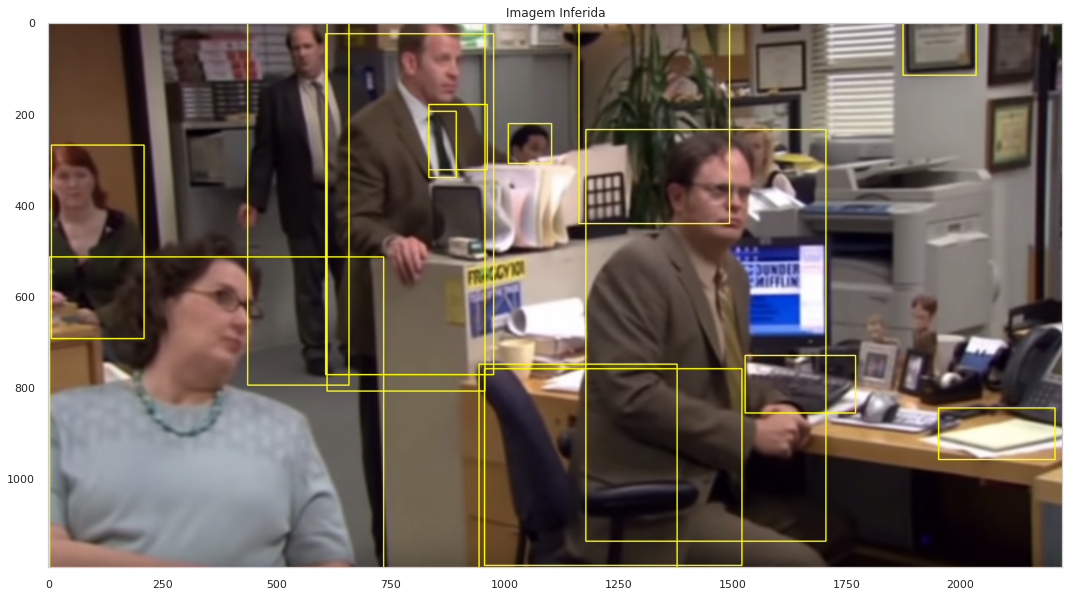

In [104]:
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Imagem Inferida")

Vamos dar uma olhada em 3 regiões de interesse detectadas.
Lembrando que estas regiões são imagens, podemos renderizá-las diretamente no Pyplot.

Text(0.5, 1.0, 'Região de interesse #1')

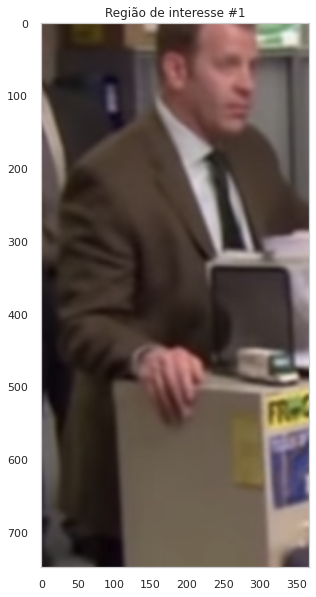

In [105]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[0]["objeto"])
plt.title("Região de interesse #1")

Text(0.5, 1.0, 'Região de interesse #1')

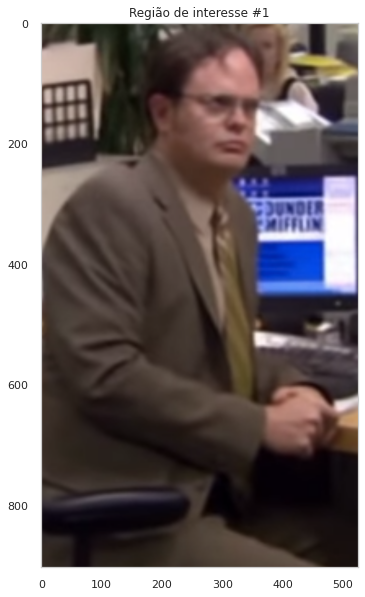

In [106]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[1]["objeto"])
plt.title("Região de interesse #1")

Text(0.5, 1.0, 'Região de interesse #1')

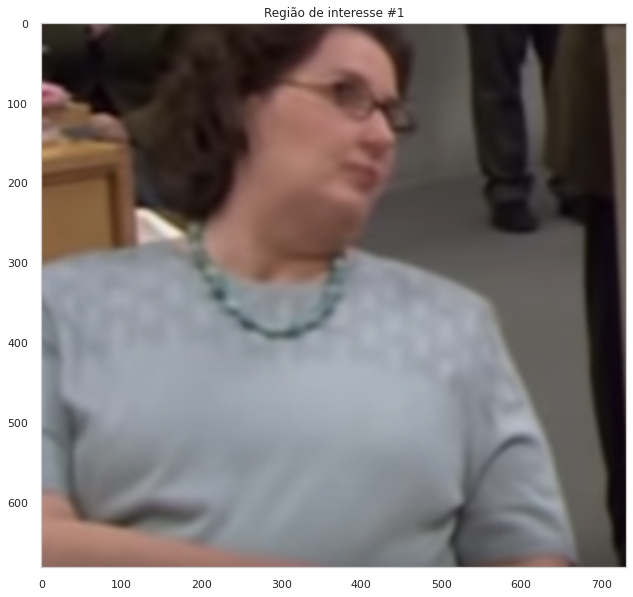

In [107]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[2]["objeto"])
plt.title("Região de interesse #1")

Perfeito, agora já estamos prontos para juntar todas as peças e começar nossa auditoria.

## 6. Auditoria automática em vídeo

Esta é a parte final do projeto.
Vamos fazer um checkpoint até aqui para ter certeza de que fizemos com sucesso os passos anteriores.

* <input type="checkbox" disabled checked> Modelo de detecção de idades treinado
* <input type="checkbox" disabled checked> Modelo de detecção de idades salvo
* <input type="checkbox" disabled checked> Modelo de detecção de idades carregado
* <input type="checkbox" disabled checked> Função de detecção de idades
* <input type="checkbox" disabled checked> Modelo de detecção de gênero treinado
* <input type="checkbox" disabled checked> Modelo de detecção de gênero salvo
* <input type="checkbox" disabled checked> Modelo de detecção de gênero carregado
* <input type="checkbox" disabled checked> Função de detecção de gênero
* <input type="checkbox" disabled checked> Função de padronização de imagens
* <input type="checkbox" disabled checked> Função de extração de faces
* <input type="checkbox" disabled checked> Função de extração de objetos

O que precisamos identificar no vídeo de auditoria:

* Homens com mais de 45 anos
* Mulheres com menos de 45 anos
* Objetos _computador portátil, celular, teclado, tv _ e _controle remoto_.

Vamos começar definindo a lista de objetos.

In [108]:
lista_objetos = [None]

Nesta parte vamos reunir tudo o que fizemos até aqui.
O algoritmo irá abrir um vídeo e, frame a frame, analisar seu conteúdo.
Após a instrução ```if is_capturing``` iremos implementar as verificações.

A execução abaixo pode demorar, pois será analisado individualmente cada frame do vídeo.

O que precisamos fazer:

* ```IMPLEMENTAR 1```: obter as faces de uma imagem. Neste caso receberamos uma lista de rostos no padrão que já vimos, ou seja, uma lista de ```rosto``` e ```coordenadas```.

* ```IMPLEMENTAR 2```: obter as a face de um item e padronizar. Lembre-se de utilizar a função de padronização que foi desenvolvida anteriormente, que tem por finalidade ajustar o tamanho da imagem e também normalizá-la.

* ```IMPLEMENTAR 3```: executar as funções de identificar a idade e gênero para a tomada de decisões de coleta de evidências.

* ```IMPLEMENTAR 4```: criar as regras de armazenamento de evidências para pessoas. Consulte as regras no início do projeto sobre quais os gêneros e idades de interesse. As regiões de interesse nesse caso, os rostos, deverão ser salvos individualmente na pasta ```resultado/homem``` e ```resultado/mulher```.

* ```IMPLEMENTAR 5```: criar as regras de armazenamento de evidências para objetos. As regiões de interesse nesse caso, os objetos, deverão ser salvos individualmente na pasta ```resultado/objetos```.

In [109]:
def predizerGenero(imagem):
    pred = modelo_genero.predict(imagem)
    return "Masculino" if np.argmax(pred) == 1 else "Feminino"

In [110]:
def predizerIdade(imagem):
    pred = modelo_idade.predict(imagem)
    return int(np.round(np.sum(pred * classes_idade_saida, axis = 1))[0])

In [113]:
#cam.release()
from keras.preprocessing.image import img_to_array

cam = cv2.VideoCapture("videos/video-1.avi")
contador = 0 
try:
    while(True):
        contador += 1
        is_capturing, imagem = cam.read()
        
        if is_capturing:
            
            # IMPLEMENTAR 1
            # Obter Faces
            faces = []
            faces = obterFaces(imagem)

            
            for idx, face in enumerate(faces):
                print("Encontrado " + str(len(faces)) + " rostos...")

                # IMPLEMENTAR 2
                # Padronizar a imagem do rosto (ROI)
                # Obtenha a imagem do rosto da variável face e armazene em imagem_rosto
                # Depois utilize a função padronizarROI, com a variável imagem_rosto para obter
                # o rosto padronizado e armazenar em rosto_padronizado
                
                imagem_rosto = None
                rosto_padronizado = None

                imagem_rosto = face["rosto"]
                print("shape image rosto", imagem_rosto.shape)

                rosto_padronizado = cv2.cvtColor(imagem_rosto, cv2.COLOR_BGR2GRAY)
                #rosto_padronizado = cv2.resize(rosto_padronizado,(224,224))
                rosto_padronizado = cv2.resize(imagem,(224,224),interpolation=cv2.INTER_AREA)
                rosto_padronizado = np.reshape(rosto_padronizado,(224,224,3))


                rosto_padronizado = np.expand_dims(rosto_padronizado, axis = 0)
                #rosto_padronizado = img_to_array(rosto_padronizado)
                rosto_padronizado = np.float32(rosto_padronizado)/255.0

                #rosto_padronizado = padronizarROI(imagem_rosto)
                
         
                # IMPLEMENTAR 3
                # Chame as funções para predizer gênero e idade com a imagem padronizada do rosto
                
                genero = None
                idade = None

                #genero = modelo_genero.predict(rosto_padronizado)
                genero = predizerGenero(rosto_padronizado)
                idade = modelo_idade.predict(rosto_padronizado)
   
                print("Gênero: " + genero + ", idade: " + str(idade))
                
                # IMPLEMENTAR 4
                # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
                # de acordo com o identificação (resultado/homem, resultado/mulher)
                # Cuidado para não sobrescrever as imagens

                if genero == "Masculino" and (idade > 45).all():
                    cv2.imwrite("resultado/homem/homem_" + str(contador) + "_" + str(idx) + ".png" , imagem_rosto)
                    print("Encontrado homem com mais que 45 anos, " + str(contador) + "_" + str(idx))

                if genero == "Feminino" and (idade <  45).all():
                    cv2.imwrite("resultado/mulher/mulher_" + str(contador) + "_" + str(idx) + ".png" , imagem_rosto)
                    print("Encontrado mulher com menos que 45 anos, " + str(contador) + "_" + str(idx))
                
            

            # IMPLEMENTAR 5
            # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
            # de acordo com o identificação (resultado/objetos)
            # Cuidado para não sobrescrever as imagens
                
            objetos = obter_objetos(imagem, lista_objetos)
            for idx, objeto in enumerate(objetos):
              imagem_objeto = objeto["objeto"]
              cv2.imwrite("resultado/objetos/objeto_" + str(contador) + "_" + str(idx) + ".png" , imagem_objeto)
                    
        else:
            break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

Interrompido


> **Critério de sucesso:** identificação de 180 imagens de homens. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 190 imagens de mulheres. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 680 imagens de objetos selecionados. Como um mesmo objeto pode aparecer em diferentes frames é comum repetir as imagens

## 7. Conclusões finais

Com base nesta jornada de construção de modelos, análises de regiões de interesse e processamento de vídeo, comente quais seriam os principais pontos de melhoria para alcançar resultados melhores em todas as etapas.

**Resposta:**

## Usando DLIB para identificar rosto em streamer

In [ ]:
!pip install dlib

In [ ]:
%ls

sample_data/


In [ ]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [ ]:
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

In [ ]:
imagem2 = cv2.imread('testes/teste-8.png')


In [ ]:
import dlib
datFile =  "shape_predictor_68_face_landmarks.dat"
#classificador_68_path = "shape_predictor_68_face_landmarks.dat"
#detector_face_dlib = dlib.get_frontal_face_detector()
classificador_dlib  = dlib.shape_predictor(datFile)

detector_face_dlib = dlib.get_frontal_face_detector()

def obter_marcos(imagem):
  faces = detector_face_dlib(imagem) 
  if len(faces) == 0:
    print("Não foi encontrada nenhuma face marcos.")
  return None
  marcos_faciais = []
  for face in faces:
    marcos_faciais.append(np.matrix([[p.x, p.y] for p in classificador_dlib(imagem, face).parts()]))
  return marcos_faciais

In [ ]:
LABIO = list(range(48, 61))

In [ ]:
def anotar_marcos(imagem, marcos_faciais):
  
  if marcos_faciais is None:
    print("Não foi identificado nenhum marco facial.") 
    return imagem

  for marco_facial in marcos_faciais:
    for idx, ponto in enumerate(marco_facial):
      centro = (ponto[0,0], ponto[0,1])
      cv2.putText(imagem, str(idx), centro, fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=0.5, color=(255, 255, 255))
      cv2.circle(imagem, centro, 3, color=(0, 255, 255), thickness=-1) 
  return imagem

In [ ]:
marcos = obter_marcos(imagem2)

In [ ]:
img_encontradas = anotar_marcos(imagem2, marcos)

Não foi identificado nenhum marco facial.


In [ ]:
# imTemp = imagem.copy()
# for p in img_encontradas:
#     cv2.circle(imTemp, p, 5, (255,0,0), -1)

# plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [ ]:
#cam_capture.release()
   
cam_capture = cv2.VideoCapture(0)

qtde_bocejos = 0

bocejo = False

try:
    while True:
        ret, image_frame = cam_capture.read()
        prev_bocejo = bocejo 

        if ret:
            image_frame, area_boca = annotate_landmarks_convex_hull_image(image_frame)

            if area_boca > 4100:
                bocejo = True
            else:
                bocejo = False

            if prev_bocejo == True and bocejo == False:
                qtde_bocejos += 1

            cv2.putText(image_frame, "bocelo "+str(qtde_bocejos), (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            cv2.putText(image_frame, "area boca "+str(area_boca), (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
           
            image_frame = cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)
            
            cv2.imwrite("imagens/camera_output_2.png", image_frame)
            
            img = PIL.Image.fromarray(image_frame, "RGB")
            buffer = BytesIO()
            img.save(buffer,format="JPEG")        
            display(Image(data=buffer.getvalue()))

            clear_output(wait=True)
            
except KeyboardInterrupt:
    cam_capture.release()
    print("Interrompido")